---
# Zillow Regression Project 
---

<img src="https://1000logos.net/wp-content/uploads/2017/12/Zillow_logo_PNG2.png" alt="Zillow" title="Zillow Logo" width="400" height="200" />

---
## Executive Summary
---

In [1]:
# add this later

---
## Plan
---

In [2]:
# add this later (if at all)

---
## Acquire
---

In [3]:
# standard imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# sklearn imports
from sklearn.metrics import mean_squared_error, explained_variance_score
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Custom module imports
import wrangle as w
import explore as e

# sns.set_palette('colorblind')  

In [4]:
# use function from wrangle module to acquire needed data, see wrangle.py for code
df = w.get_zillow_sfr_data()

In [5]:
df.shape

(28124, 8)

In [6]:
df.describe()

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxamount,taxvaluedollarcnt,yearbuilt,fips
count,28124.000000,28124.000000,28077.000000,28123.000000,2.812300e+04,28053.000000,28124.000000
mean,3.309487,2.316509,1934.930014,6508.829263,5.350049e+05,1963.773179,6049.521121
std,0.943073,1.016983,995.684457,8221.720405,7.076811e+05,23.108952,21.302136
min,0.000000,0.000000,240.000000,51.260000,1.000000e+03,1878.000000,6037.000000
25%,3.000000,2.000000,1278.000000,2705.330000,1.986360e+05,1950.000000,6037.000000
50%,3.000000,2.000000,1675.000000,4735.280000,3.827980e+05,1961.000000,6037.000000
75%,4.000000,3.000000,2326.000000,7528.405000,6.327670e+05,1979.000000,6059.000000
max,12.000000,11.000000,17245.000000,276797.830000,2.385837e+07,2016.000000,6111.000000


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28124 entries, 0 to 28123
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bedroomcnt                    28124 non-null  float64
 1   bathroomcnt                   28124 non-null  float64
 2   calculatedfinishedsquarefeet  28077 non-null  float64
 3   taxamount                     28123 non-null  float64
 4   taxvaluedollarcnt             28123 non-null  float64
 5   yearbuilt                     28053 non-null  float64
 6   fips                          28124 non-null  float64
 7   transactiondate               28124 non-null  object 
dtypes: float64(7), object(1)
memory usage: 1.9+ MB


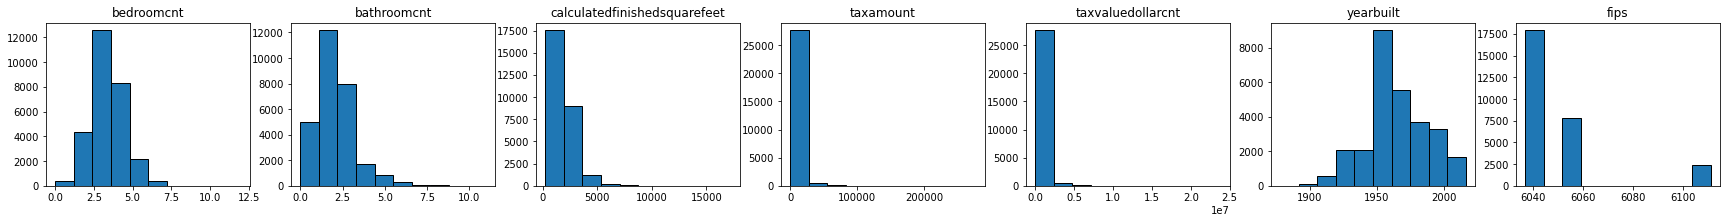

In [8]:
w.plot_distributions(df)

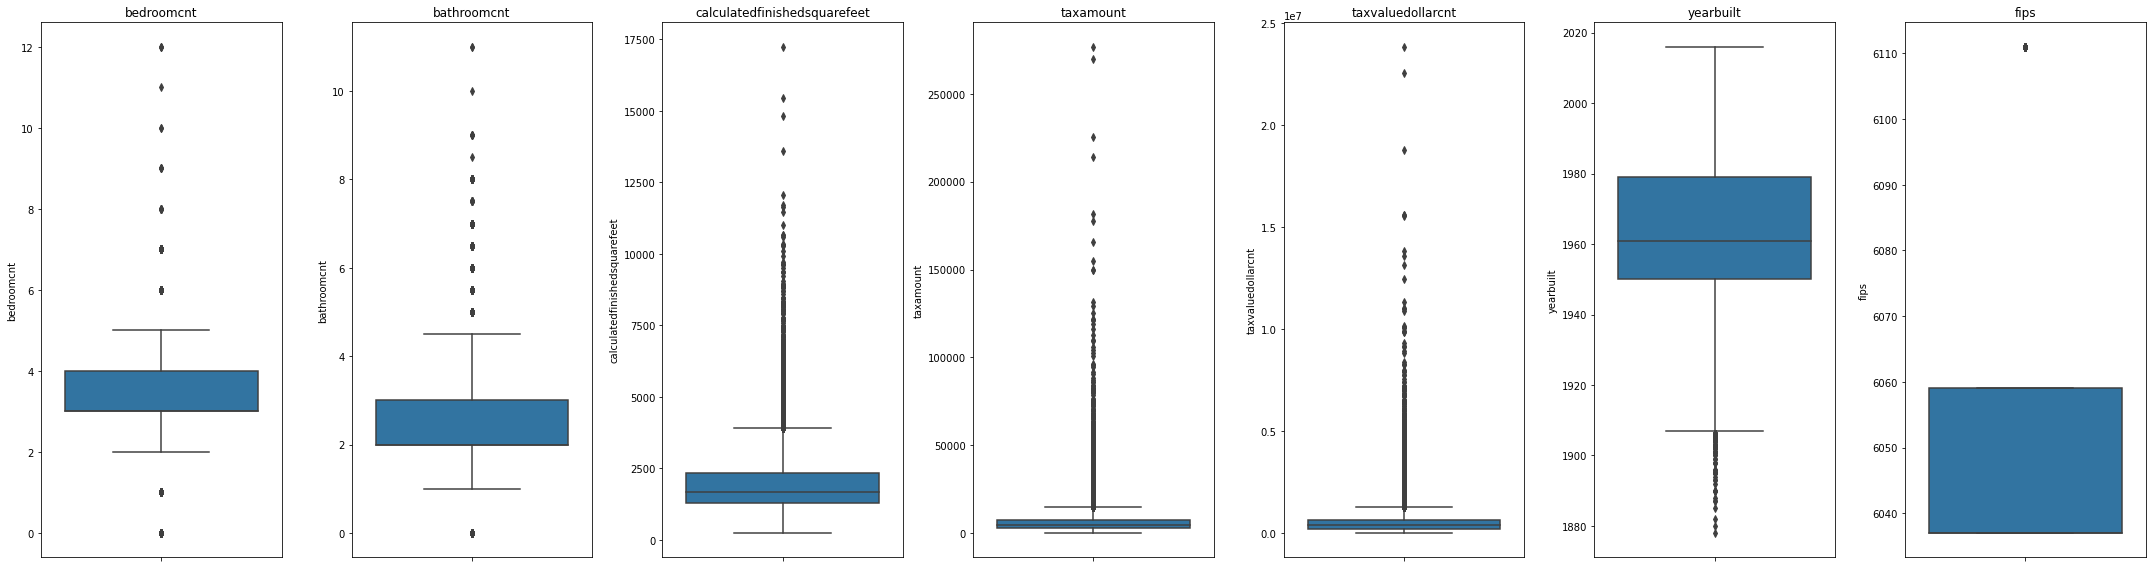

In [9]:
w.plot_boxplots(df)

### Takeaways:
- Have some outliers/erroneous data in all columns
- fips isn't actually numeric and should be changed to string

---
## Prepare
---

### Clean
- Dropped nulls
- Dropped duplicate rows
- Reformatted `fips` as string data type and preserved leading 0
- Adjusted data types of columns to more appropriately represent information
- Renamed columns for readability
- Added `tax_rate` column
- Eliminated outliers using `1.5*IQR Rule`

In [10]:
# use function to clean data, see wrangle.py for code
df = w.wrangle_zillow_no_split()
df.head()

,bedroom_cnt,bathroom_cnt,sqft,prop_tax,appraised_value,year_built,fips,transaction_date,tax_rate
0,3,2.0,1316,2627.48,205123.0,1923,06037,2017-07-21,0.012809
1,3,2.0,1458,2319.90,136104.0,1970,06037,2017-06-23,0.017045
2,2,1.0,1421,543.69,35606.0,1911,06037,2017-06-30,0.015270
3,4,3.0,2541,9819.72,880456.0,2003,06059,2017-06-01,0.011153
4,3,2.0,1491,1399.27,107110.0,1955,06037,2017-08-23,0.013064


In [11]:
df.head()

,bedroom_cnt,bathroom_cnt,sqft,prop_tax,appraised_value,year_built,fips,transaction_date,tax_rate
0,3,2.0,1316,2627.48,205123.0,1923,06037,2017-07-21,0.012809
1,3,2.0,1458,2319.90,136104.0,1970,06037,2017-06-23,0.017045
2,2,1.0,1421,543.69,35606.0,1911,06037,2017-06-30,0.015270
3,4,3.0,2541,9819.72,880456.0,2003,06059,2017-06-01,0.011153
4,3,2.0,1491,1399.27,107110.0,1955,06037,2017-08-23,0.013064


---
### Encode

In [12]:
# fips will need to be encoded since it is categorical
# I will drop columns derived from target since they will not be used in model
df_modeling = pd.get_dummies(data=df, columns=['fips'])
df_modeling = df_modeling.drop(columns=['prop_tax', 'tax_rate', 'transaction_date'])
df_modeling.head()

,bedroom_cnt,bathroom_cnt,sqft,appraised_value,year_built,fips_06037,fips_06059,fips_06111
0,3,2.0,1316,205123.0,1923,1,0,0
1,3,2.0,1458,136104.0,1970,1,0,0
2,2,1.0,1421,35606.0,1911,1,0,0
3,4,3.0,2541,880456.0,2003,0,1,0
4,3,2.0,1491,107110.0,1955,1,0,0


---
### Split

In [13]:
# split encoded df for scaling and modeling
train_encoded, validate_encoded, test_encoded = w.split_zillow(df_modeling)
print(train_encoded.shape, validate_encoded.shape, test_encoded.shape)
train_encoded.head()

(17309, 8) (2140, 8) (2162, 8)


,bedroom_cnt,bathroom_cnt,sqft,appraised_value,year_built,fips_06037,fips_06059,fips_06111
22113,3,2.0,1422,525223.0,1947,1,0,0
11771,4,3.0,1688,414349.0,1960,1,0,0
16027,4,2.5,2044,424126.0,1992,0,1,0
3443,3,2.0,1215,431814.0,1971,0,0,1
19279,3,3.0,2192,599606.0,1975,1,0,0


In [14]:
# split df for exploration
df_exploration = df.drop(columns=['prop_tax', 'tax_rate', 'transaction_date'])
train_explore, validate_explore, test_explore = w.split_zillow(df_exploration)
print(train_explore.shape, validate_explore.shape, test_explore.shape)
train_explore.head()

(17309, 6) (2140, 6) (2162, 6)


,bedroom_cnt,bathroom_cnt,sqft,appraised_value,year_built,fips
22113,3,2.0,1422,525223.0,1947,06037
11771,4,3.0,1688,414349.0,1960,06037
16027,4,2.5,2044,424126.0,1992,06059
3443,3,2.0,1215,431814.0,1971,06111
19279,3,3.0,2192,599606.0,1975,06037


---
### Scale

In [15]:
# scale dfs that will be used in modeling
cols = ['bedroom_cnt', 'bathroom_cnt', 'sqft', 'year_built']
train_scaled, validate_scaled, test_scaled = w.add_scaled_columns(train_encoded, validate_encoded, test_encoded, MinMaxScaler(), cols)
train_scaled.head()

,appraised_value,fips_06037,fips_06059,fips_06111,bedroom_cnt_scaled,bathroom_cnt_scaled,sqft_scaled,year_built_scaled
22113,525223.0,1,0,0,0.333333,0.333333,0.297665,0.352381
11771,414349.0,1,0,0,0.666667,0.666667,0.383917,0.476190
16027,424126.0,0,1,0,0.666667,0.500000,0.499351,0.780952
3443,431814.0,0,0,1,0.333333,0.333333,0.230545,0.580952
19279,599606.0,1,0,0,0.333333,0.666667,0.547341,0.619048


---
## Explore
---

### Tax Rate Distributions for each County

In [16]:
df.fips.value_counts()

06037    13287
06059     6258
06111     2066
Name: fips, dtype: Int64

**Fips Transation**
- 06037 = Los Angeles County, CA
- 06059 = Orange County, CA
- 06111 = Ventura County, CA

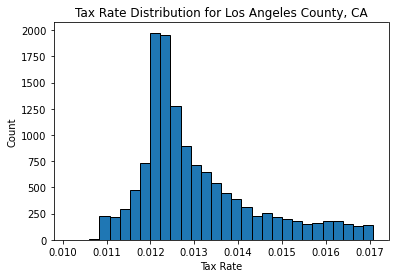

In [17]:
df.tax_rate[df.fips == '06037'].hist(edgecolor='black', bins=30)
plt.grid(False)
plt.title('Tax Rate Distribution for Los Angeles County, CA')
plt.xlabel('Tax Rate')
plt.ylabel('Count');

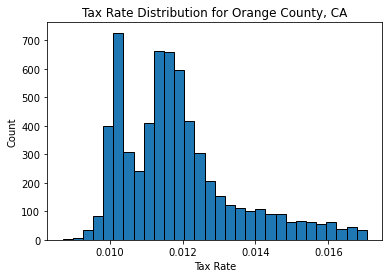

In [18]:
df.tax_rate[df.fips == '06059'].hist(edgecolor='black', bins=30)
plt.grid(False)
plt.title('Tax Rate Distribution for Orange County, CA')
plt.xlabel('Tax Rate')
plt.ylabel('Count');

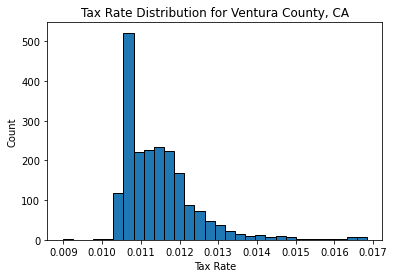

In [19]:
df.tax_rate[df.fips == '06111'].hist(edgecolor='black', bins=30)
plt.grid(False)
plt.title('Tax Rate Distribution for Ventura County, CA')
plt.xlabel('Tax Rate')
plt.ylabel('Count');

### Univariate

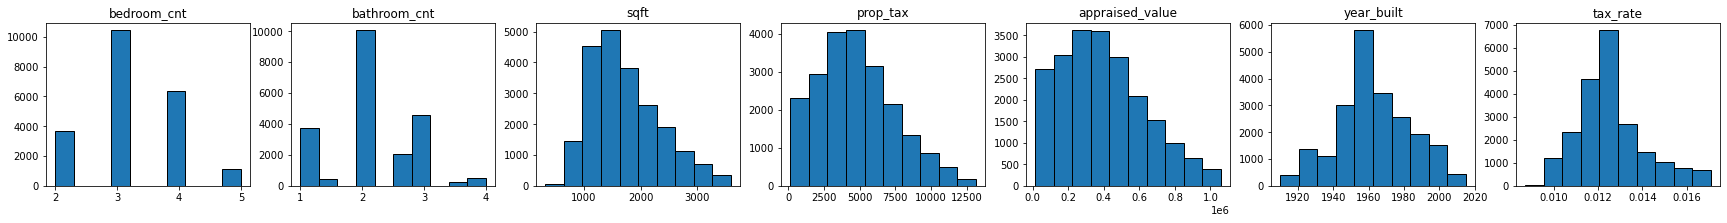

In [20]:
# check distributions after cleaning and removing outliers
w.plot_distributions(df)

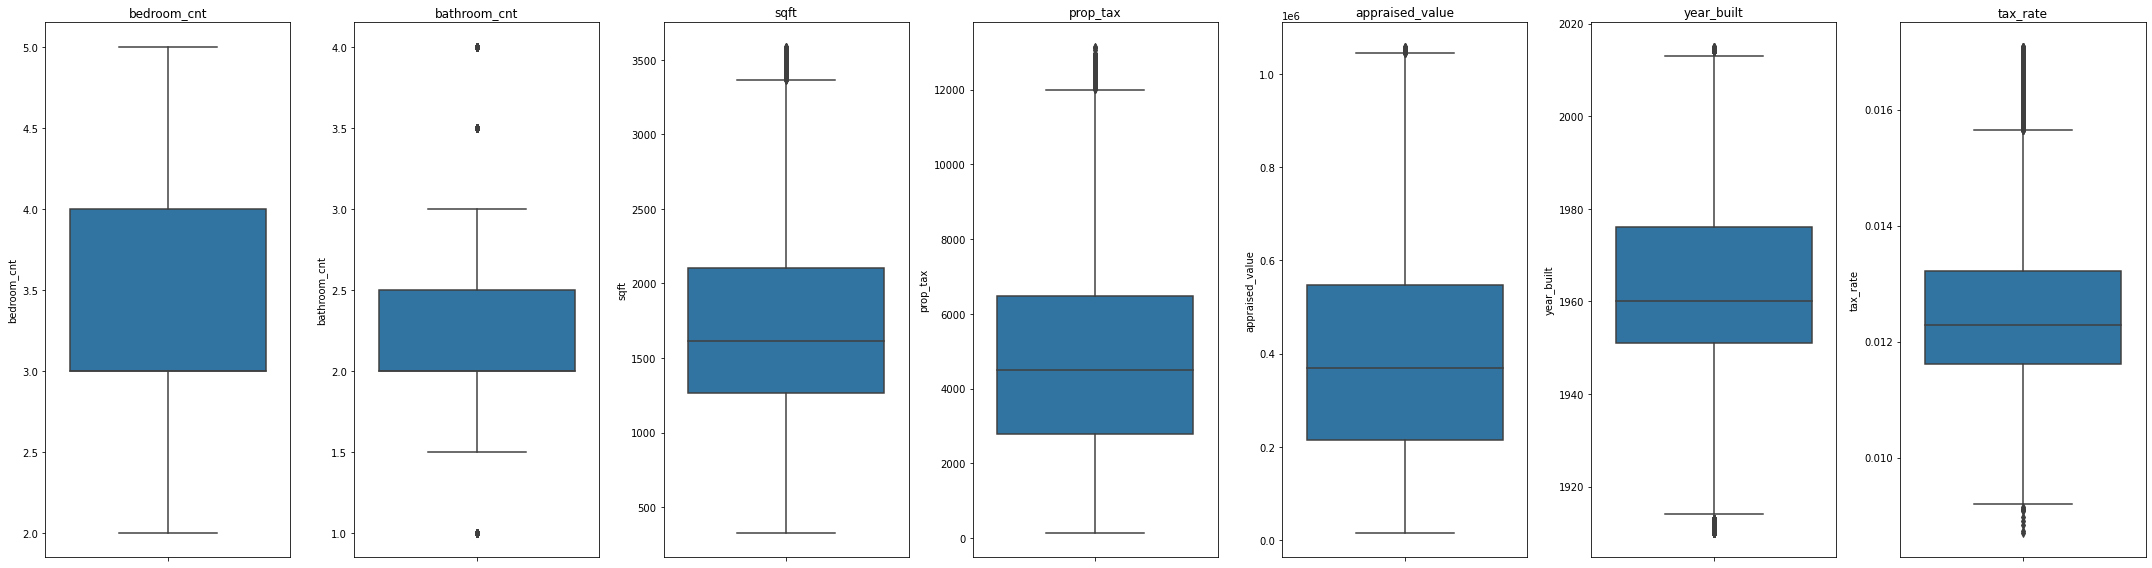

In [21]:
# check boxplots after cleaning and removing outliers
w.plot_boxplots(df)

---
### Bivariate

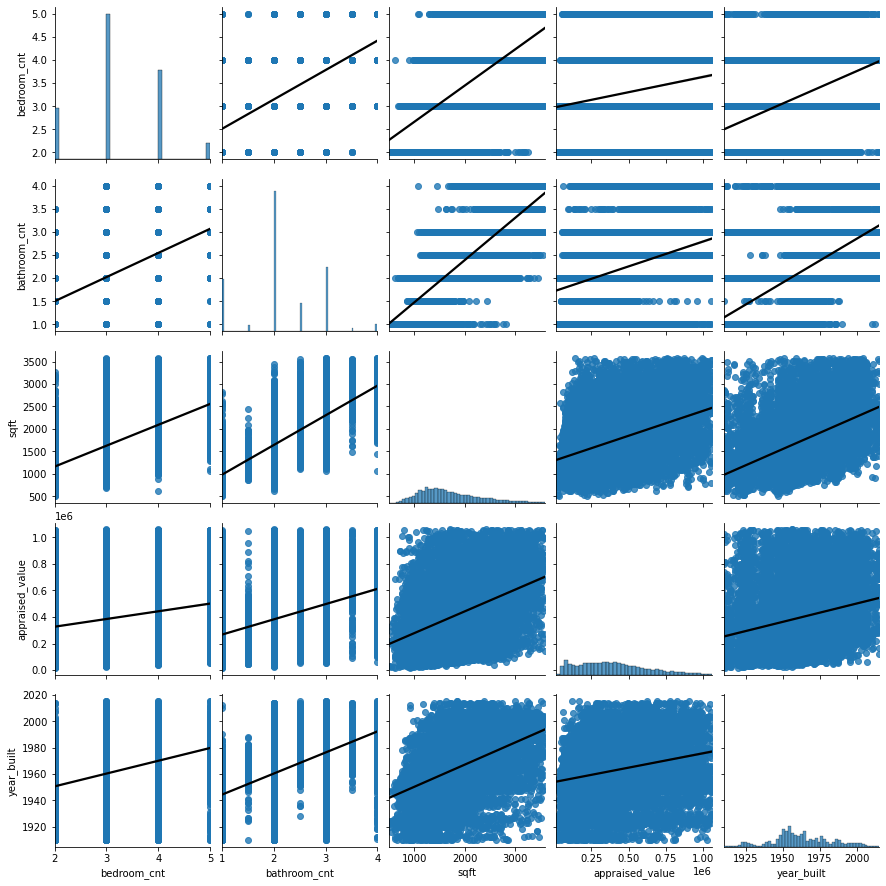

In [22]:
e.plot_variable_pairs(train_explore)

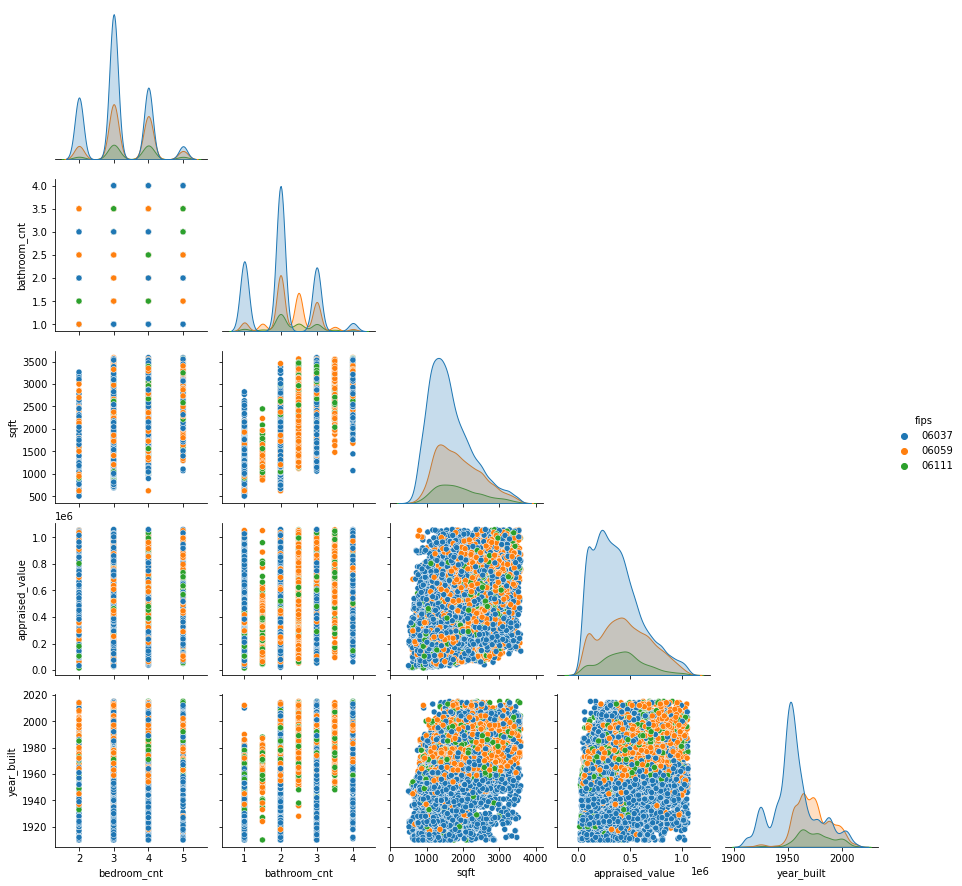

In [23]:
e.plot_variable_pairs_cat_hue(train_explore)

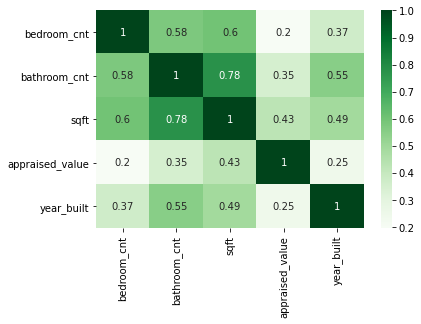

In [24]:
sns.heatmap(train_explore.corr(), annot=True, cmap='Greens');

---
## Model/Evaluate
---